# Hopfield model and data reconstuction

Group 6:

**Theivan Pasupathipillai: 2057446**

**Mojtaba Roshana : 2050955**

**Roya Joulaei Vijouyeh : 2050954**

**Asal Rangrazi Asl : 2046832**

**Elham Khosravi : 2040482**


### Description
The [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network), also introduced in the course Models of Theoretical Physics, is a simple model of neuron dynamics that can be mapped to a spin system with inhomogeneous couplings. Hence, Hopfield networks are described as spin glasses, with spins Si  and spin-spin interactions $J_{ij} S_i S_j$ . The full Hamiltonian of the system is $H[S]=-\sum_{i<j} J_{ij}S_i S_j$. The network in practice is used to store patterns in its spin-spin coupling constants $J_{ij}=J_{ji}$ . A pattern ${x_i|i=1,...,N}$ is a given configuration of spins ${x_i=S_i}$, each equal to +1 or -1. It could represent for example a black (+1) and white (-1) pixel in a picture. The properties of the Hopfield network include the fact that:

a. it can store P different patterns $x^a=\{x^a_{i}\}$ $(1\le a \le P)$ as long as P is much smaller than the number N of spins.

b. it can recover a pattern $x^a$ from a corrupted ya by energy minimization of the spins of $y^a$.

### Datasets

a. a set of random arrays and patterns;

b. the MNIST database of handwritten digits. In this case, the group should find a way to define the P=10 patterns relative to the 10 digits 0,1,2,..,9.


### Assignments

The project aims at simulating a Hopfield network by:

a. Generate or read from file P patterns and imprint their vaules in the couplings Jij between spins, by fixing the couplings to constant values $J_{ij} = \sum_{a=1}^P x^a_i x^a_j / N$. Note that a mean field version is adopted if all pairs $1\le i \le j \le P$ are used (this is what was presented in the theoretical course). If a 2d image is considered for a pattern, one can also explore other versions, such as nonzero coupling only between spins within a distance R from each other.

b. Generate corrupted patterns $\{y^a\}$, for example, by copying each $y^a_i = x^a_i$ with probability $q<1$, otherwise setting  $y^a_i = -x^a_i$ with probability $(1 – q)$.

c. Recover the patterns from progressively more corrupted $y^a$, obtained by increasing $q$, till the point where it becomes difficult to get back to the original patterns xa. The recovery may be implemented by iterating the “sign” rule (each new spin at time t+1 equals $S_i(t+1) = \sum_j J_{ij}S_j(t)$ obtained from spins at time t) starting from $S(0)=y^a$ . It can also be attempted by a minimization of the Hamiltonian with a Monte Carlo based on random spin flips and the Metropolis rule.

d. Check how much pattern overlap is allowed while keeping each pattern distinguishable from the others.

e. Describe the clearly and coherently the findings of the previous points.

### Contacts

Marco Baiesi <marco.baiesi@unipd.it>

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy.random as npr
import pandas as pd
import random
import matplotlib

npr.seed(123)

## Functions

In [2]:
# Takes a vector of patterns (matrices) and return the matrix of coupling
def set_coupling(X_patterns): 

    J = np.zeros(shape=(X_patterns[0].size, X_patterns[0].size))
    
    for i in range(X_patterns.shape[0]):
        J = J + X_patterns[i].flatten()[:,np.newaxis] * X_patterns[i].flatten()
        #J = J - np.diag(J.diagonal())
    
    return J/(X_patterns[0].size)


# Takes an image and a threshold and return a pattern of spins
# pixel is spin up when its value is greater than the mean of the 
# non zero pixels * threshold
def pattern_generator(image_in, threshold):
    image = image_in.copy().astype('float64')
    mask_positive = image_in > 0.
    image[image_in >= threshold*image_in[mask_positive].mean()] = 1.
    image[image_in < threshold*image_in[mask_positive].mean()] = -1.

    return image

# Takes a vector of images and a threshold and return the patterns of spins
# pixel is spin up when its value is greater than the mean of the 
# non zero pixels * threshold
def multipattern_generator(images, threshold):
    vector_of_images = images.copy()
    patterns = []
    
    for image in vector_of_images:
        patterns.append(pattern_generator(image, threshold))
        
    return np.array(patterns)
    

# Takes a pattern and a probability q of copying the pattern
# Return a currupted copy of the input pattern based on the probability q
def corrupt_pattern(X_pattern, q): #q probability of copying from the original pattern
    Y_pattern = X_pattern.copy()
    extractions = npr.rand(X_pattern.shape[0],X_pattern.shape[1])
    mask_to_flip = extractions > q
    Y_pattern[mask_to_flip] = -1* X_pattern[mask_to_flip]
    
    return Y_pattern


# Same as corrupt pattern but it takes a vector of original patterns and return 
# a vector of currupted patterns
def multicorrupt_pattern(X_patterns, q): #q probability of copying from the original pattern
    Y_patterns = X_patterns.copy()
    corrupted_ones = []
    for pat in Y_patterns:
        corrupted_ones.append(corrupt_pattern(pat, q))
        
    return np.array(corrupted_ones)


# Takes initial pattern, the coupling coefficients to use for the evolution
# And the maximum number of steps allowed, if metropolis_spins is not false then does the montecarlo evolution based
# on the metropolis rule, flipping n=metropolis_spins at each iteration
def pattern_evolution(X_pattern_i, J, steps, energy=False, metropolis_spins=False):
    
    if metropolis_spins==False: #markov chain evolution
        X_before = X_pattern_i.copy()
        en = []
        
        for i in range(steps):
            #X_pattern = np.sign(np.dot(J,X_pattern.flatten()).reshape(X_pattern.shape))
            X_next = np.dot(J,X_before.flatten()).reshape(X_before.shape)
            X_next = np.sign(X_next)
            X_next[X_next==0] = 1.
            en.append([i, hamiltonian(X_next,J)])

            if np.all(X_before==X_next): #If we get to the minima we exit the for
                break
            X_before = X_next.copy()

        if energy==True:
            return X_next, np.array(en)

        else:
            return X_next
        
    else: #montecarlo evolution one spin flip at each iteration
        pattern = X_pattern_i.copy()
        en = []
        
        for i in range(steps):
            random_i = npr.randint(low=0, high=pattern.size, size=metropolis_spins)

            energy_before = hamiltonian(pattern, J)
            flip_pattern = pattern.flatten().copy()
            flip_pattern[random_i] = -1. * flip_pattern[random_i]
            flip_pattern = flip_pattern.reshape(pattern.shape)

            energy_after = hamiltonian(flip_pattern, J)
            if(energy_after < energy_before):
                pattern = flip_pattern.copy()
                en.append(energy_after)
        
        if energy==True:
            return pattern, en
        
        else:
            return pattern

        
def multipattern_evolution(X_patterns, J, steps, energy=False, metropolis_spins=False):
    return [pattern_evolution(pat, J, steps, energy=energy, metropolis_spins=metropolis_spins) for pat in X_patterns]



# Takes two patterns and return the overlap
def overlap(pat1, pat2):
    matrix = pat1.copy()*pat2.copy()
    return matrix.flatten().sum()/matrix.size
    
# Takes a vector of patterns and return the overlap matrix between this patterns
def overlap_matrix(X_patterns):
    patterns = X_patterns.copy()
    P = patterns.shape[0]
    ov_mat = np.zeros((P,P))
    
    for i in range(P-1):
        for j in range(i+1, P):
            ov_mat[i,j] = overlap(patterns[i],patterns[j])
            
    
    ov_mat = ov_mat + np.transpose(ov_mat)
    np.fill_diagonal(ov_mat,1.) #fill the diagonal with 1, each pattern completely overlap with itself
    return ov_mat

# Takes the number of pattern I want to load the dataset dictionary
# If randomize true I shuffle the dataset
# Return a vector of P patterns
def load_patterns(P, data_dict, randomize=False):
    patterns = []
    delta = 1.
    for i in range(P):
        
        if randomize:
            variable = data_dict[i].copy()
            npr.shuffle(variable)
            patterns.append(pattern_generator(variable[0], threshold=delta))
        
        else:
            patterns.append(pattern_generator(data_dict[i][0], threshold=delta))
            #patterns.append(pattern_generator_2(data_dict[i][0]))
        
    return np.array(patterns)

# Takes a configuration of the system and the coupling coefficient and return 
# the energy
def hamiltonian(X_pattern, J):
    pattern = X_pattern.copy()
    
    return -0.5*np.dot(pattern.flatten(), np.dot(J,pattern.flatten()))

#plot the P chosen patterns given as input
def plot_patterns(patterns, figsize=(8,4)):
    P = patterns.shape[0]

    fig, axs = plt.subplots(nrows=1, ncols=P, figsize=figsize)

    for ax, pat in zip(axs, patterns):
        ax.imshow(pat)
        ax.set_yticks([])
        ax.set_xticks([])

    

### The dataset used to simulate the hopfield model is the mnist dataset of digits
To map one image, which is a matrix of real positive value, into a pattern, which is a matrix of {+1,-1} we set an arbitrary threshold. If the value of the pixel is greater than the threshold than it will be mapped to spin +1, otherwise it will be mapped to spin -1.

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data() # we need to map the image into patterns and then compute
#the coupling coefficients
threshold = 1. #for mapping the image in patterns
data_dict = { i : multipattern_generator(X_train[y_train==i], threshold) for i in range(10)}

### We start from taking two patterns from the mnist data ('0' and '1')

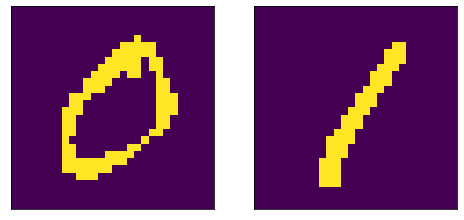

In [4]:
P =  2# How many patterns
patterns = load_patterns(P, data_dict,randomize=False) # Load
J_coupling = set_coupling(patterns) # Set coupling coefficients

plot_patterns(patterns)

### We corrupt each pattern

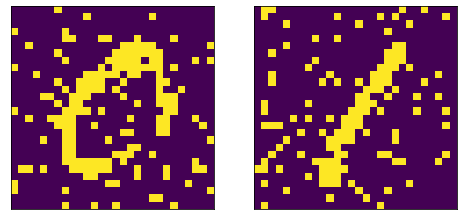

In [5]:
q = 0.9 # probabilty of copying from the original patterns
corrupted_patterns = multicorrupt_pattern(patterns, q)

plot_patterns(corrupted_patterns)

### and try to retrieve the original ones through the evolution defined by the coupling coefficients

Did they converge to the original patterns?  True


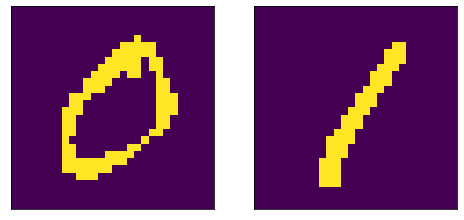

In [16]:
max_steps = 100000 # maximum iteration for the evolution
evo_patterns = np.array([pattern_evolution(pat, J_coupling, max_steps) for pat in corrupted_patterns])

plot_patterns(evo_patterns)
print("Did they converge to the original patterns? ", np.all(patterns==evo_patterns))

### We try also the metropolis rule to see if we can retrieve the original patterns but it's way less efficient in term of computational time, so we did't use it for the following points

The energy of our system is given by the following formula

$Energy (t) = -1/2 \sum_{i,j} J_{ij} S_i(t) S_j(t)$


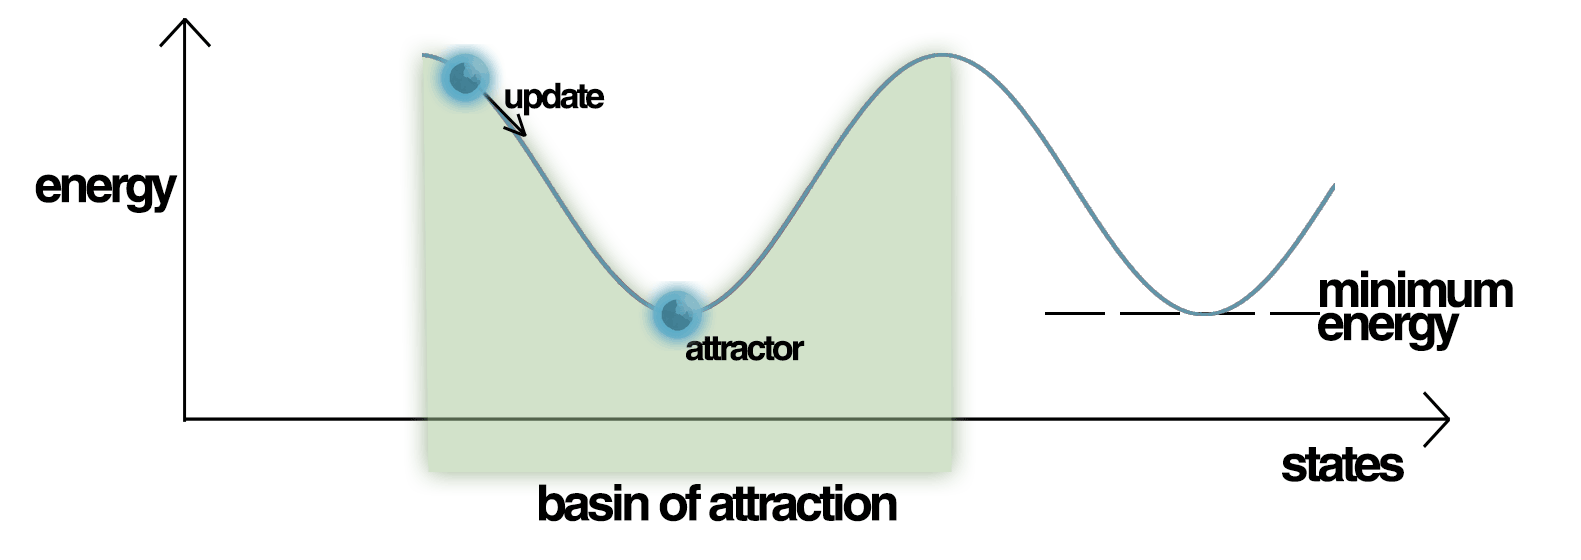

Did they converge to the original patterns?  False


/tmp/ipykernel_47599/380330953.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  evo_patterns = np.array([pattern_evolution(pat, J_coupling, max_steps, metropolis_spins=3, energy=True) for pat in corrupted_patterns])
/tmp/ipykernel_47599/380330953.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print("Did they converge to the original patterns? ", np.all(patterns==evo_patterns))


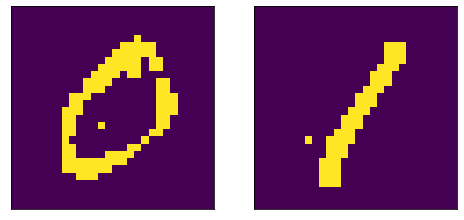

In [17]:
max_steps = 1000000 # maximum iteration for the evolution
evo_patterns = np.array([pattern_evolution(pat, J_coupling, max_steps, metropolis_spins=3, energy=True) for pat in corrupted_patterns])

plot_patterns(evo_patterns[:,0])
print("Did they converge to the original patterns? ", np.all(patterns==evo_patterns))

Text(0.5, 1.0, 'Energy minimization Montecarlo/Metropolis')

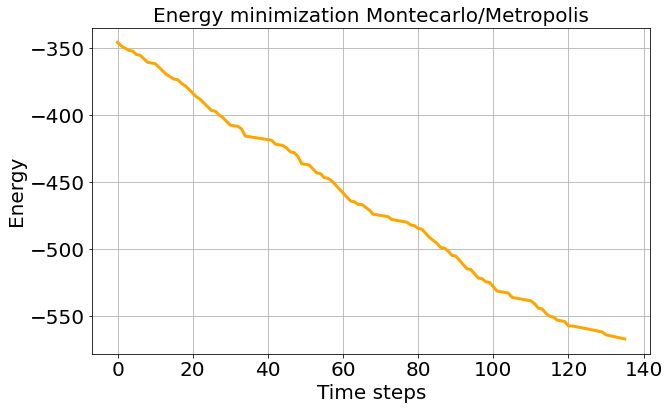

In [26]:
x = np.arange(0,len(evo_patterns[:,1][0]))

plt.figure(figsize=(10,6))

plt.plot(x , evo_patterns[:,1][0], lw=3, color='orange')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Energy', fontsize=20)
plt.xlabel('Time steps', fontsize=20)
plt.grid()
plt.title('Energy minimization Montecarlo/Metropolis', fontsize=20)

### We now try to retrieve the same two patterns corrupting them with different copying probabilities

In [46]:
q_probs = [i*1/10. for i in range(1,10)] # reverse 0.1, 0.2 ... up to 0.9
q_probs.reverse()

max_steps = 100 # maximum iteration for the evolution

corrupted_series = list() # all corrupted data for all different q
evo_series = list() # all evolution of the corrupted data for all differet q

for q in q_probs:
    corrupted_patterns = multicorrupt_pattern(patterns, q)
    corrupted_series.append(corrupted_patterns)
    evo_series.append(np.array(multipattern_evolution(corrupted_patterns, J_coupling, max_steps)))
    
corrupted_series = np.array(corrupted_series)
evo_series = np.array(evo_series)

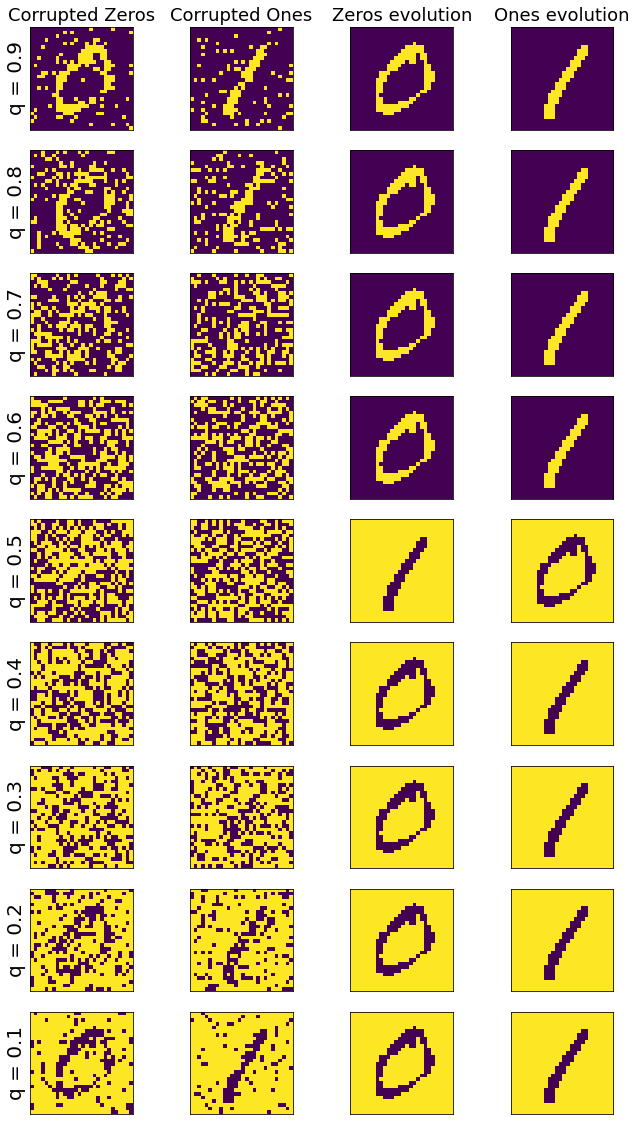

In [47]:
#plot of the results
figure, axs = plt.subplots(9,4, figsize=(11,20), sharey=True)

for j in range(9): # rows of the plot 9x4
    axs[j,0].imshow(corrupted_series[j,0])    
    axs[j,1].imshow(corrupted_series[j,1])
    axs[j,2].imshow(evo_series[j,0])
    axs[j,3].imshow(evo_series[j,1])
    
    #stylistic adjustments
    
    if j==0: #add titles of the first graphs to have title of the column
            axs[j,0].set_title('Corrupted Zeros', fontsize=18)
            axs[j,1].set_title('Corrupted Ones', fontsize=18)
            axs[j,2].set_title('Zeros evolution', fontsize=18)
            axs[j,3].set_title('Ones evolution', fontsize=18)
    
    string = 'q = ' + str(q_probs[j])
    axs[j,0].set_ylabel(string, fontsize=20)
    
    #get rid of ticks in graphs
    axs[j,0].set_xticks([])
    axs[j,1].set_xticks([])
    axs[j,2].set_xticks([])
    axs[j,3].set_xticks([])
    
    axs[j,0].set_yticks([])
    axs[j,1].set_yticks([])
    axs[j,2].set_yticks([])
    axs[j,3].set_yticks([])


### On the previous plot
With these two patterns stored the Hopfield model works pretty well. Up to q=0.6 we are able to retrieve the original patterns. q = 0.5 corresponds to completly random patterns so we expect the model to fail in retrieving the patterns (or at least fail 1/2 of the time). If q > 0.5 the model retrieves the completely flipped orginal pattern, this is consistent because the energy of the evolved system is exactly the same as the energy of the original patterns.

### Now we want to augment the number of patterns stored by the model

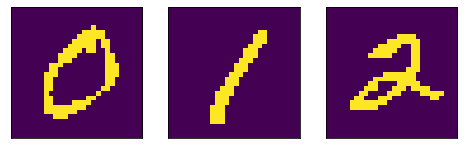

In [48]:
P =  3 # How many patterns
patterns = load_patterns(P, data_dict,randomize=False) # Load
J_coupling = set_coupling(patterns) # Set coupling coefficients

plot_patterns(patterns)

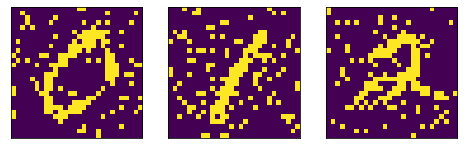

In [49]:
q = 0.9 # probabilty of copying from the original patterns
corrupted_patterns = multicorrupt_pattern(patterns, q)

plot_patterns(corrupted_patterns)


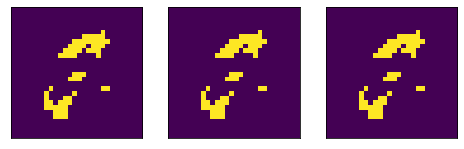

In [50]:
evolved_patterns = np.array(multipattern_evolution(corrupted_patterns,J_coupling,steps=10))

plot_patterns(evolved_patterns)

### Hopfield model fails
Already with 3 patterns the hopfield model is not able to start from a corrupted version of the patterns and retrieve the originals. This is linked to the patterns overlap. With the mnist data there is already a good amount of overlap between patterns because all the digits are centered; This high overlap is due to the down spins, which are the "frame" of the digit (blue in the previous plots).

### We want now to study the amount of overlap that allows us to store P pattern (1)
In order to reduce the overlap we pad the patterns with random spins "frames", we corrupt them and make them evolve using the coupling coefficients. The number of patterns that we can store should increase.

In [51]:
#function to pad the patterns with random spins
def random_pad(vec, pad_width, *_, **__):
    vec[:pad_width[0]] = npr.choice([-1.,1.], size=pad_width[0])
    vec[vec.size-pad_width[1]:] = npr.choice([-1.,1.], size=pad_width[1])

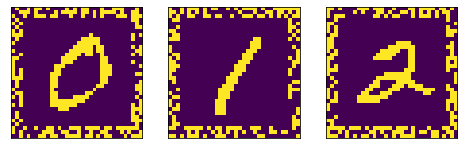

In [52]:
patterns = load_patterns(3, data_dict) #load from 2 to 10 image patterns

padding_form = (3,3) # The thickness of the frame #with 20 not good for 10 pattern but with 25 yes
padding_value = (-1,-1)
#patterns_rase_dim = np.array( [np.pad(pat, padding_form, "constant", constant_values=padding_value) for pat in patterns])

padded_patterns = np.array( [np.pad(pat, (padding_form, padding_form), mode=random_pad) for pat in patterns])

ov_mat_rase_dim = overlap_matrix(padded_patterns)
J_coupling = set_coupling(padded_patterns)

plot_patterns(padded_patterns) 

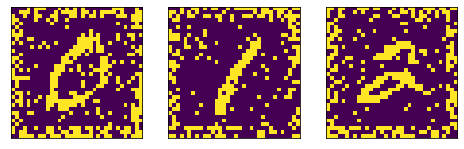

In [53]:
q = 0.9 # probabilty of copying from the original patterns
padded_corrupted_patterns = multicorrupt_pattern(padded_patterns, q)

plot_patterns(padded_corrupted_patterns)

Did they converge to the original patterns?  True


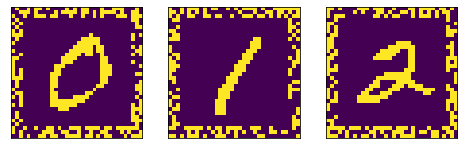

In [54]:
evolved_padded_patterns = np.array(multipattern_evolution(padded_corrupted_patterns,J_coupling,steps=10))

plot_patterns(evolved_padded_patterns)
print("Did they converge to the original patterns? ", np.all(padded_patterns==evolved_padded_patterns))

### Of course the overlap decreased, and now we can correctly store 3 patterns

In [55]:
overlap_m_3pat = overlap_matrix(patterns) #overlap matrix before, when we failed to store 3 pattern
overlap_m_3pat_pad = overlap_matrix(padded_patterns) #overlpa matrix, after padding with random spins

print("Overlap matrix before padding")
print(overlap_m_3pat)

print("\nOverlap matrix after padding")
print(overlap_m_3pat_pad)

Overlap matrix before padding
[[1.         0.67091837 0.64285714]
 [0.67091837 1.         0.69132653]
 [0.64285714 0.69132653 1.        ]]

Overlap matrix after padding
[[1.         0.4100346  0.42387543]
 [0.4100346  1.         0.49134948]
 [0.42387543 0.49134948 1.        ]]


### We now want to perfom a statistical analysis on the amount of overlap that allows to correcty store P patterns
We try to store P patterns (P=2,3...,10) and if we fail, we reduce the amount of overlap by padding with a frame of random spins (thickness = 1 spin) and then try again, until we manage to store the P patterns correctly.
when we store P patterns correctly we save the overlap matrix.

In [36]:
###the loading function need a dictionary in input, should pass the dictionary as input to the function
def study_overlap_threshold_padding(data_dict):

    paddings =  [(i,i) for i in range(0,31)] #generate padding forms
    t = 100 # max evolution steps
    q = 0.9 # probability of copying each spin during corruption of the pattern (corruption needed to check stability)
    pad_index = 0

    overlap_matrices = {}
    patterns_original = load_patterns(10, data_dict, randomize=True) #choose random sample of 10 digits
    
    for patterns_number in range(2,11): # for on the number of patterns that I memorize

        check = False # assuming pattern not correctly stored
        patterns = patterns_original[:patterns_number]
        while True:
            if (check or pad_index==31): # if we save all the patterns correctly I exit and try to save one more pattern
                break

             #load from 2 to 10 image patterns

            if pad_index != 0: #if needed i pad them
                patterns = np.array( [np.pad(pat, (paddings[pad_index], paddings[pad_index]), mode=random_pad) for pat in patterns])

            J_coupling = set_coupling(patterns) #set the coupling for P patterns

            overlap_mat = overlap_matrix(patterns) #calculate the overlap matrix
             #sum the amount of overlap


            for original in patterns: #for to check if every pattern is correctly memorized and stable

                corrupt = corrupt_pattern(original,q) #corruption with copying probability = q


                evo_original = pattern_evolution(original, J_coupling, t) # check if the original is stationary for t steps
                evo_corrupt = pattern_evolution(corrupt, J_coupling, t) #check if the original is an attract for its corrupted version

                is_stationary = np.all(original==evo_original)
                is_minimum = np.all(original==evo_corrupt)

                check = is_stationary and is_minimum

                if not check: # if they're not correctly stored I pad them and try again 
                    pad_index += 1
                    break

        if(check==True):
            if(patterns_number in overlap_matrices.keys()): # if I have already the key append the matrix
                overlap_matrices[patterns_number].append(overlap_mat)
                
            else: #Otherwise I start the list
                overlap_matrices[patterns_number] = [overlap_mat]
            
        else:
            overlap_matrices.append(np.nan)
    
    return overlap_matrices

In [37]:
iterations = 1

overlap_study = pd.read_pickle('./overlap_matrices_pad.pickle')
#overlap_study = study_overlap_threshold_padding(data_dict)
#overlap_study = pd.DataFrame(overlap_study)

for i in range(iterations):
    good_overlap = pd.DataFrame(study_overlap_threshold_padding(data_dict))
    
    overlap_study = overlap_study.append(good_overlap, ignore_index=True)
    overlap_study.to_pickle('./overlap_matrices_pad.pickle')

In [31]:
overlap1 = pd.read_pickle('./overlap_matrices_pad.pickle')

tot_overlap = pd.DataFrame()
single_overlaps = pd.DataFrame()

for col in overlap1.columns:
    tot_overlap[col] = overlap1[col].apply(lambda x : (x.sum()-np.trace(x))/2.)
    single_overlaps[col] = overlap1[col].apply(lambda x : x[np.triu_indices(col, k=1)])

#I want to split the overlap matrix in single overlaps
means = []
stds = []
for col in single_overlaps.columns: #for on each columns

    for j in range(single_overlaps[col][0].shape[0]): #for on number of components of the vectors in the columns
        string = str(col) + '_pat_ov_' + str(j)
        single_overlaps[string] = single_overlaps[col].apply(lambda x : x[j])
        means.append([col,single_overlaps[string].mean()])
        stds.append([col, single_overlaps[string].std()])
    
means = np.array(means)
stds = np.array(stds)

/tmp/ipykernel_47599/3702420166.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  single_overlaps[string] = single_overlaps[col].apply(lambda x : x[j])


#### Plot of the distribution of the overlaps between two pattern (where we stored 3 patterns in total)
The distribution are similar with different patterns P stored, they show a peek around the same value at fixed P.

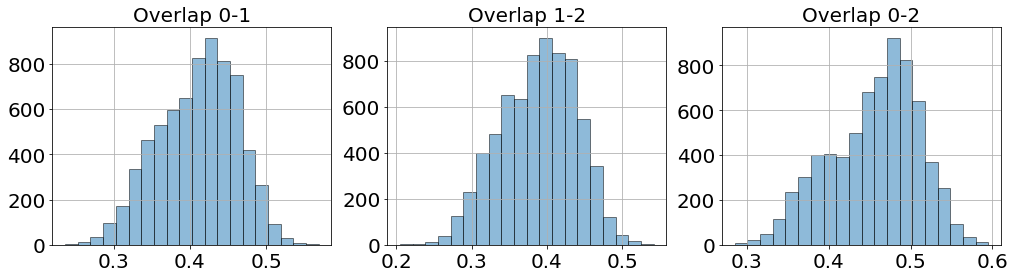

In [65]:
col = 3 #how many pattern are stored
n_overlaps = single_overlaps[col][0].shape[0]

figure, axs = plt.subplots(1,n_overlaps, figsize=(17,4))

for j in range(n_overlaps): #for on number of components of the vectors in the columns
    string = str(col) + '_pat_ov_' + str(j)
    axs[j].hist(single_overlaps[string], bins=20, alpha=0.5, ec='black')
    axs[j].grid()
    title = 'Overlap ' + str(j) +'-' + str(j+1)
    
    if j == 2:
        title = 'Overlap ' + str(0) +'-' + str(j)
    axs[j].set_title(title, size=20)
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 

    


Text(0.5, 1.0, 'Overlap study on padded mnist dataset ')

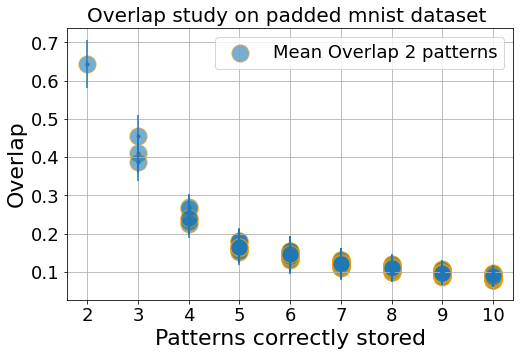

In [82]:
plt.figure(figsize=(8,5))
plt.scatter(means[:,0], means[:,1], s=300, edgecolors='orange', alpha=0.6, label='Mean Overlap 2 patterns')
plt.errorbar(means[:,0], means[:,1], yerr=stds[:,1], fmt='.')
plt.grid()
plt.legend(fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Overlap', fontsize=22)
plt.xlabel('Patterns correctly stored', fontsize=22)
plt.title('Overlap study on padded mnist dataset ', fontsize=20)


### The overlap seams to decrease exponentialy so we tryed to fit it

In [115]:
from scipy import optimize, stats
from scipy.stats import chisquare

In [116]:
def f(x,a,b):
    return a * np.exp(x*b)

n degrees of freedom = 7
Chi squared = 0.4706017268307448
p-value = 0.9995471650205242


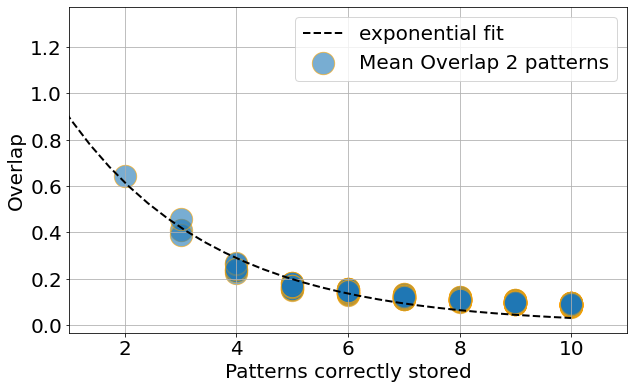

In [132]:
y_obs = [means[:,1][means[:,0]== i][0] for i in range(2,11)]


popt, pcov = optimize.curve_fit(f,  np.arange(2,11),  y_obs, maxfev = 1000)
x = np.linspace(0,10, 30)
y = popt[0] * np.exp(popt[1]*x)

plt.figure(figsize=(10,6))
plt.plot(x,y, label='exponential fit',lw=2,color='black', linestyle='--')
plt.ylabel('Overlap', fontsize=20)
plt.xlabel('Patterns correctly stored', fontsize=20)

plt.xlim(1,11)
plt.grid()
plt.scatter(means[:,0], means[:,1], s=500, edgecolors='orange', alpha=0.6, label='Mean Overlap 2 patterns')


sigma = [stds[:,1][stds[:,0]== i][0] for i in range(2,11)]
y_fit = f(np.arange(2,11), popt[0], popt[1])

plt.legend(fontsize=20)

#plt.axis('equal')

ndof = len(y_obs) - 2
print("n degrees of freedom =", ndof)

chi2 = np.sum(((y_obs - y_fit)**2) / sigma)
print('Chi squared =',chi2)

pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue)

### We want now to study the amount of overlap that allows us to store P pattern (2)
but we have to modify out mnist patterns in order to reduce the overlap.
The idea is to try to store P patterns with P going from 1 to 10 (the 10 digits), if at some point a fail then I reduce the overlap by picking random spins that are allined in at least 2 patterns and flip one of then.

In [28]:
###Function to reduce the overlap

def reduce_overlap(X_patterns, spins_to_flip=1):
    patterns = X_patterns.copy()
    n = patterns.shape[0]
    while True:

        mask_overlap = patterns.sum(axis=0).flatten()==-1*n # all sites where I have spin down in all pattern
        mask_overlap2 = patterns.sum(axis=0).flatten()== n # all sites where I have spin up in all pattern
        
        if mask_overlap.shape[0]>0 or mask_overlap2.shape[0]>0 or n==1:
            break
        else:
            n = n-1
    
    if mask_overlap2.sum() > mask_overlap.sum():
        mask_overlap = mask_overlap2
    random_index = npr.randint(low=0, high=patterns.shape[0]) # to pick the pattern to change

    pattern_variable = patterns[random_index].flatten() #variable needed to flip
    _ = pattern_variable[mask_overlap] #variable needed to flip
    if(_.shape[0]!=0):
        random_indeces = npr.randint(low=0, high=_.shape[0], size = spins_to_flip) # random indeces of the spins to flip
        _[random_indeces] = _[random_indeces] * (-1.)
        pattern_variable[mask_overlap] = _
        patterns[random_index] = pattern_variable.reshape((28,28))

    return patterns

def study_overlap_threshold(data_dict, spins_to_flip=10):
    
    t = 100 # max evolution steps
    q = 0.9 # probability of copying each spin during corruption of the pattern (corruption needed to check stability)
    pad_index = 0
    count = 0 #counter, after N non succsessfull iteration
    overlap_matrices = {}
    patterns_original = load_patterns(10, data_dict, randomize=True) #choose random sample of the 10 digits
    
    for patterns_number in range(2,5): # for on the number of patterns that I memorize (I stop at 5 patterns because cannot go on)

        check = False # assuming pattern not correctly stored
        patterns = patterns_original[:patterns_number]
        while True:
            if (check or count): # if we save all the patterns correctly I exit and try to save one more pattern
                break

             #load from 2 to 10 image patterns

            J_coupling = set_coupling(patterns) #set the coupling for P patterns

            overlap_mat = overlap_matrix(patterns) #calculate the overlap matrix
             #sum the amount of overlap


            for original in patterns: #for to check if every pattern is correctly memorized and stable

                corrupt = corrupt_pattern(original,q) #corruption with copying probability = q


                evo_original = pattern_evolution(original, J_coupling, t) # check if the original is stationary for t steps
                evo_corrupt = pattern_evolution(corrupt, J_coupling, t) #check if the original is an attract for its corrupted version

                is_stationary = np.all(original==evo_original)
                is_minimum = np.all(original==evo_corrupt)

                check = is_stationary and is_minimum

                if not check: # if they're not correctly stored I pad them and try again
                    pat = patterns.copy()
                    patterns = reduce_overlap(patterns, spins_to_flip=spins_to_flip)
                    
                    if np.all(pat==patterns):
                        count += 1
                        
                        if count >10:
                            return np.nan # if I get stuck I return nothing
                        
                    break

        if(check==True):
            if(patterns_number in overlap_matrices.keys()): # if I have already the key append the matrix
                overlap_matrices[patterns_number].append(overlap_mat)
                
            else: #Otherwise I start the list
                overlap_matrices[patterns_number] = [overlap_mat]
            
        else:
            overlap_matrices.append(np.nan)
    
    return overlap_matrices


Did they converge to the original patterns?  True


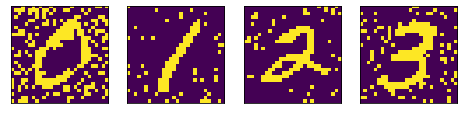

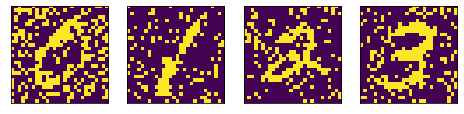

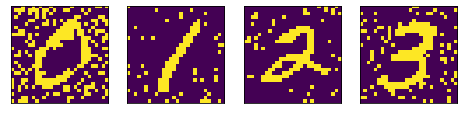

In [29]:
#Test of the function to reduce the overlap
P = 4 # How many patterns
patterns = load_patterns(P, data_dict,randomize=False) # Load

while True:

    patterns = reduce_overlap(patterns, spins_to_flip=10)
    J_coupling = set_coupling(patterns)



    q = 0.9 # probabilty of copying from the original patterns
    corrupted_patterns = multicorrupt_pattern(patterns, q)


    evolved_patterns = np.array(multipattern_evolution(corrupted_patterns,J_coupling,steps=10))


    
    if np.all(patterns==evolved_patterns):
        break

plot_patterns(patterns)
plot_patterns(corrupted_patterns)
plot_patterns(evolved_patterns)

print("Did they converge to the original patterns? ", np.all(patterns==evolved_patterns))

### this method for reducing the overlaps works fine up to 4 patterns. After that it becomes more difficult to store 5 patterns without augmenting the dimension of the system(padding)
We can still perform a statistical analysis on the amount of overlap which allows to store P pattern (this time P=2,3,4)


In [32]:
iterations = 1

overlap_study = pd.read_pickle('./overlap_matrices.pickle')
#overlap_study_2 = study_overlap_threshold(data_dict)
#overlap_study_2 = pd.DataFrame(overlap_study_2)

for i in range(iterations):
    good_overlap = pd.DataFrame(study_overlap_threshold(data_dict))
    
    overlap_study_2 = overlap_study_2.append(good_overlap, ignore_index=True)
    overlap_study_2.to_pickle('./overlap_matrices.pickle')

In [53]:
overlap2 = pd.read_pickle('./overlap_matrices.pickle')

tot_overlap2 = pd.DataFrame()
single_overlaps2 = pd.DataFrame()

for col in overlap2.columns:
    tot_overlap2[col] = overlap2[col].apply(lambda x : (x.sum()-np.trace(x))/2.)
    single_overlaps2[col] = overlap2[col].apply(lambda x : x[np.triu_indices(col, k=1)])

#I want to split the ovrla
means2 = []
stds2 = []
for col in single_overlaps2.columns: #for on each columns

    for j in range(single_overlaps2[col][0].shape[0]): #for on number of components of the vectors in the columns
        string = str(col) + '_pat_ov_' + str(j)
        single_overlaps2[string] = single_overlaps2[col].apply(lambda x : x[j])
        means2.append([col,single_overlaps2[string].mean()])
        stds2.append([col, single_overlaps2[string].std()])
    
means2 = np.array(means2)
stds2 = np.array(stds2)

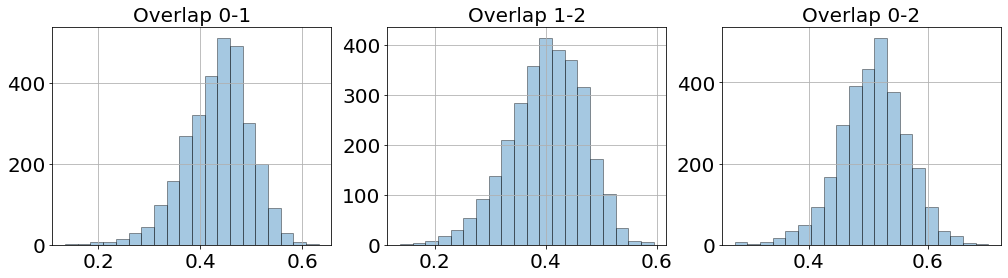

In [55]:
col = 3
n_overlaps = single_overlaps2[col][0].shape[0]

figure, axs = plt.subplots(1,n_overlaps, figsize=(17,4))

for j in range(n_overlaps): #for on number of components of the vectors in the columns
    string = str(col) + '_pat_ov_' + str(j)
    axs[j].hist(single_overlaps2[string], bins=20, alpha=0.4, ec='black')
    axs[j].grid()
    
    title = 'Overlap ' + str(j) +'-' + str(j+1)
    
    if j == 2:
        title = 'Overlap ' + str(0) +'-' + str(j)
    axs[j].set_title(title, size=20)
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 

    

(1.0, 10.0)

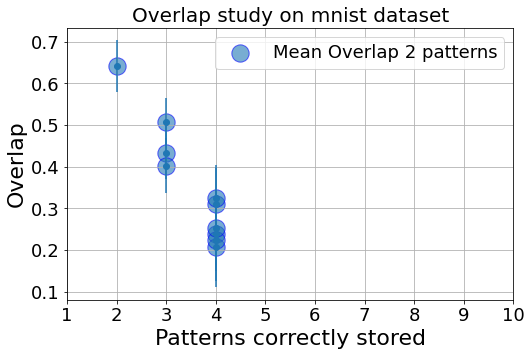

In [86]:
plt.figure(figsize=(8,5))
plt.scatter(means2[:,0], means2[:,1], s=300, edgecolors='blue', alpha=0.6, label='Mean Overlap 2 patterns')
plt.errorbar(means2[:,0], means2[:,1], yerr=stds2[:,1], fmt='o')
plt.grid()

plt.legend(fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Overlap', fontsize=22)
plt.xlabel('Patterns correctly stored', fontsize=22)
plt.title('Overlap study on mnist dataset', fontsize=20)
plt.xlim(1,10)

### On the previous plot

Even though reducing the amount of the overlap in this way doesn't allow us to store all the 10 patterns, we can still show that the amount of overlap must decrease

## Random dataset analysis
To be complete we used also random generated patterns to perform the same statiscal analysis on the overlaps. Trying to store P patterns, pad them with random spins until they are correctly stored and then save the overlap matrix. The random patterns are generated just by taking each mnist data patterns we have, and then randomly rearrange the spins.

In [58]:
spinup_mnist = {} # dictionary with mean value of spin up
for key in data_dict:
    spinup_mnist[key] = [int(np.sum(data_dict[key][0] + 1)/2.)]
    
    for j in range(1,data_dict[key].shape[0]):
        spinup_mnist[key].append(int(np.sum(data_dict[key][j] + 1)/2.)) # saving number of spin up per pattern

In [59]:
random_patterns = {} #dictionary with the random patterns

for key in data_dict:
    random_indeces = random.sample(range(28*28), int(spinup_mnist[key][0])) # pick n random indeces (they will be the spins up)
    pat = (np.zeros(shape=(28,28))-1.).flatten() # start from a matrix of -1
    
    pat[random_indeces] = pat[random_indeces] + 2 # flip the random spins (-1 +2 = +1)
    
    random_patterns[key] = [pat.reshape(28,28)]# save the pattern in the dictionary
    
    for j in range(1,data_dict[key].shape[0]):
        random_indeces = random.sample(range(28*28), int(spinup_mnist[key][j])) # estraggo n indici a caso
        pat = (np.zeros(shape=(28,28))-1.).flatten() # definisco
        
        pat[random_indeces] = pat[random_indeces] + 2 # flip the random spins

        random_patterns[key].append(pat.reshape(28,28))# save the pattern in the dictionary

In [76]:
iterations = 1

overlap_study_rnd = pd.read_pickle('./overlap_matrices_pad_random.pickle')
#overlap_study_rnd = study_overlap_threshold_padding(random_patterns)
#overlap_study_rnd = pd.DataFrame(overlap_study_rnd)


for i in range(iterations):
    good_overlap_random = pd.DataFrame(study_overlap_threshold_padding(random_patterns))
    
    overlap_study_rnd = overlap_study_rnd.append(good_overlap_random, ignore_index=True)
    overlap_study_rnd.to_pickle('./overlap_matrices_pad_random.pickle')

In [57]:
overlap_rand = pd.read_pickle('./overlap_matrices_pad_random.pickle')

tot_overlap_rand = pd.DataFrame()
single_overlaps_rand = pd.DataFrame()

for col in overlap_rand.columns:
    tot_overlap_rand[col] = overlap_rand[col].apply(lambda x : (x.sum()-np.trace(x))/2.)
    single_overlaps_rand[col] = overlap_rand[col].apply(lambda x : x[np.triu_indices(col, k=1)])

#I want to split the overlap in the matrix
means_rand = []
stds_rand = []
for col in single_overlaps_rand.columns: #for on each columns

    for j in range(single_overlaps_rand[col][0].shape[0]): #for on number of components of the vectors in the columns
        string = str(col) + '_pat_ov_' + str(j)
        single_overlaps_rand[string] = single_overlaps_rand[col].apply(lambda x : x[j])
        means_rand.append([col,single_overlaps_rand[string].mean()])
        stds_rand.append([col, single_overlaps_rand[string].std()])
    
means_rand = np.array(means_rand)
stds_rand = np.array(stds_rand)

/tmp/ipykernel_47599/695900065.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  single_overlaps_rand[string] = single_overlaps_rand[col].apply(lambda x : x[j])


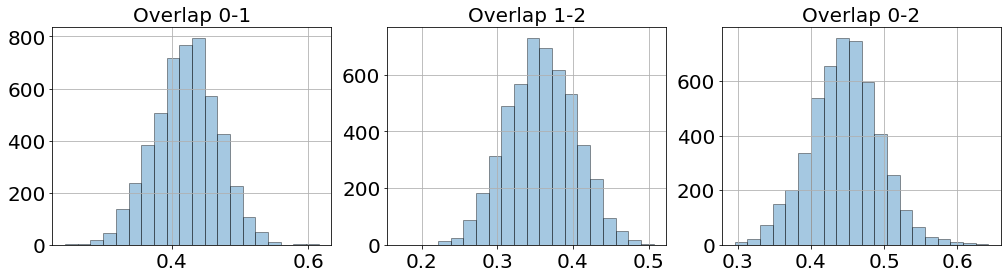

In [63]:
col = 3
n_overlaps = single_overlaps_rand[col][0].shape[0]

figure, axs = plt.subplots(1,n_overlaps, figsize=(17,4))

for j in range(n_overlaps): #for on number of components of the vectors in the columns
    string = str(col) + '_pat_ov_' + str(j)
    axs[j].hist(single_overlaps_rand[string], bins=20, alpha=0.4, ec='black')
    axs[j].grid()
    
    title = 'Overlap ' + str(j) +'-' + str(j+1)
    
    if j == 2:
        title = 'Overlap ' + str(0) +'-' + str(j)
    axs[j].set_title(title, size=20)
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 

    

Text(0.5, 1.0, 'Overlap study on random dataset')

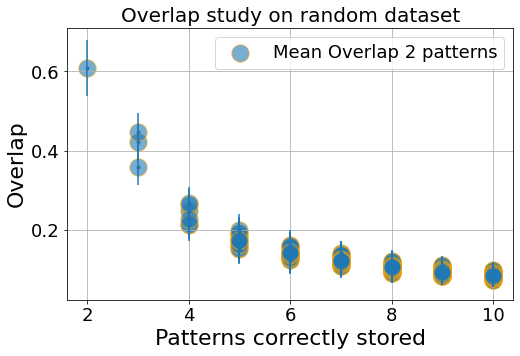

In [67]:
plt.figure(figsize=(8,5))
plt.scatter(means_rand[:,0], means_rand[:,1], s=300, edgecolors='orange', alpha=0.6, label='Mean Overlap 2 patterns')
plt.errorbar(means_rand[:,0], means_rand[:,1], yerr=stds_rand[:,1], fmt='.')
plt.grid()
plt.legend(fontsize=18)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Overlap', fontsize=22)
plt.xlabel('Patterns correctly stored', fontsize=22)
plt.title('Overlap study on random dataset', fontsize=20)


### Exponential fit

n degrees of freedom = 7
Chi squared = 0.332965064288751
p-value = 0.9998577337770841


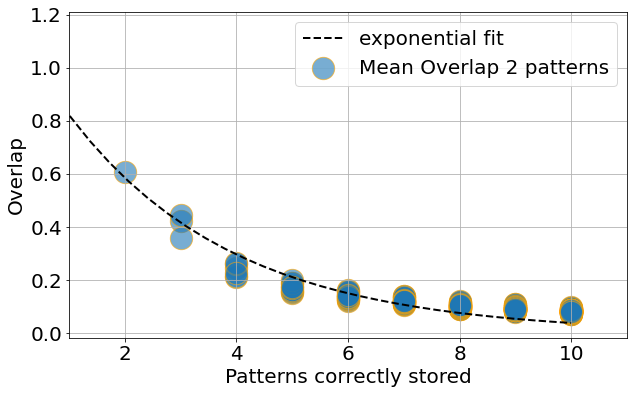

In [133]:
y_obs = [means_rand[:,1][means_rand[:,0]== i][0] for i in range(2,11)]


popt, pcov = optimize.curve_fit(f,  np.arange(2,11),  y_obs, maxfev = 1000)
x = np.linspace(0,10, 30)
y = popt[0] * np.exp(popt[1]*x)

plt.figure(figsize=(10,6))
plt.plot(x,y, label='exponential fit',lw=2,color='black', linestyle='--')
plt.ylabel('Overlap', fontsize=20)
plt.xlabel('Patterns correctly stored', fontsize=20)

plt.xlim(1,11)
plt.grid()
plt.scatter(means_rand[:,0], means_rand[:,1], s=500, edgecolors='orange', alpha=0.6, label='Mean Overlap 2 patterns')


sigma = [stds_rand[:,1][stds_rand[:,0]== i][0] for i in range(2,11)]
y_fit = f(np.arange(2,11), popt[0], popt[1])

plt.legend(fontsize=20)

#plt.axis('equal')

ndof = len(y_obs) - 2
print("n degrees of freedom =", ndof)

chi2 = np.sum(((y_obs - y_fit)**2) / sigma)
print('Chi squared =',chi2)

pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue)